In [7]:
pip install scikeras[tensorflow]


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [ ]:
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout


In [94]:
df = pd.read_csv("C:/Users/muthu/Downloads/TSLA.csv")

In [95]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [96]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [97]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [100]:
df.columns = df.columns.str.strip()  # remove spaces
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [101]:

# Select only the close/adj close price
df = df[['Adj Close']].rename(columns={'Adj Close':'Close'})


In [102]:
df = df.fillna(method='ffill')  # forward fill


In [103]:


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)


In [105]:
#create sequences function
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)


In [106]:
#build train and test set for 1,5,10 days
# 1‑day window
X1, y1 = create_sequences(scaled_data, window=1)

# 5‑day
X5, y5 = create_sequences(scaled_data, window=5)

# 10‑day
X10, y10 = create_sequences(scaled_data, window=10)

def train_test_split(X, y, ratio=0.8):
    idx = int(len(X) * ratio)
    return X[:idx], X[idx:], y[:idx], y[idx:]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5)
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10)


In [107]:
#Reshape for RNN and LSTM

X1_train = X1_train.reshape(X1_train.shape[0], X1_train.shape[1], 1)
X1_test  = X1_test.reshape(X1_test.shape[0],  X1_test.shape[1], 1)

X5_train = X5_train.reshape(X5_train.shape[0], X5_train.shape[1], 1)
X5_test  = X5_test.reshape(X5_test.shape[0],  X5_test.shape[1], 1)

X10_train = X10_train.reshape(X10_train.shape[0], X10_train.shape[1], 1)
X10_test  = X10_test.reshape(X10_test.shape[0],  X10_test.shape[1], 1)


In [ ]:
#simple RNN
def build_rnn(units=50, dropout_rate=0.2):
    model = Sequential([
        SimpleRNN(units, input_shape=(None, 1)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [109]:
# LSTM define
def build_lstm(units=50, dropout_rate=0.2):
    model = Sequential([
        LSTM(units, input_shape=(None, 1)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [112]:
#Train RNN 1 day

rnn_1d = build_rnn(units=50, dropout_rate=0.2)
rnn_1d.fit(X1_train, y1_train, epochs=30, batch_size=32, verbose=1)

pred_rnn1 = rnn_1d.predict(X1_test)
pred_rnn1_inv = scaler.inverse_transform(pred_rnn1)
y1_test_inv = scaler.inverse_transform(y1_test)

print("RNN 1‑day MSE:", mean_squared_error(y1_test_inv, pred_rnn1_inv))



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0267
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3167e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3173e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8056e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4627e-04
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1639e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3845e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1692e-04
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0401e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0599e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7211e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9037e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s

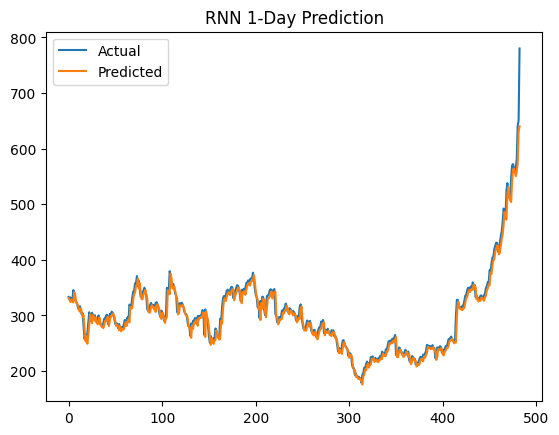

In [111]:


plt.plot(y1_test_inv, label='Actual')
plt.plot(pred_rnn1_inv, label='Predicted')
plt.title("RNN 1‑Day Prediction")
plt.legend(); plt.show()


In [113]:
lstm_1d = build_lstm(units=50, dropout_rate=0.2)
lstm_1d.fit(X1_train, y1_train, epochs=30, batch_size=32, verbose=1)

pred_lstm1 = lstm_1d.predict(X1_test)
pred_lstm1_inv = scaler.inverse_transform(pred_lstm1)

print("LSTM 1‑day MSE:", mean_squared_error(y1_test_inv, pred_lstm1_inv))



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1207e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3279e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0114e-04
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9137e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9840e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1413e-04
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6537e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9735e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3981e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4671e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

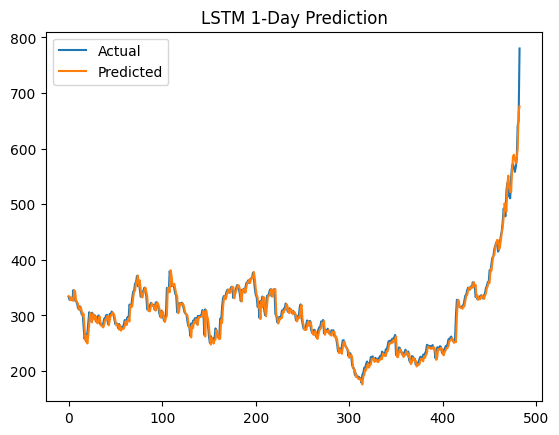

In [116]:
plt.plot(y1_test_inv, label='Actual')
plt.plot(pred_lstm1_inv, label='Predicted')
plt.title("LSTM 1‑Day Prediction")
plt.legend(); plt.show()


In [117]:
rnn_5d = build_rnn(units=50, dropout_rate=0.2)
rnn_5d.fit(X5_train, y5_train, epochs=30, batch_size=32)

pred_rnn5 = rnn_5d.predict(X5_test)
pred_rnn5_inv = scaler.inverse_transform(pred_rnn5)
y5_test_inv = scaler.inverse_transform(y5_test)

print("RNN 5‑day MSE:", mean_squared_error(y5_test_inv, pred_rnn5_inv))




Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3557e-04
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6709e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6056e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5908e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1372e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6019e-04 
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9277e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9346e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3370e-04 
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2912e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6751e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3838e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2513e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━

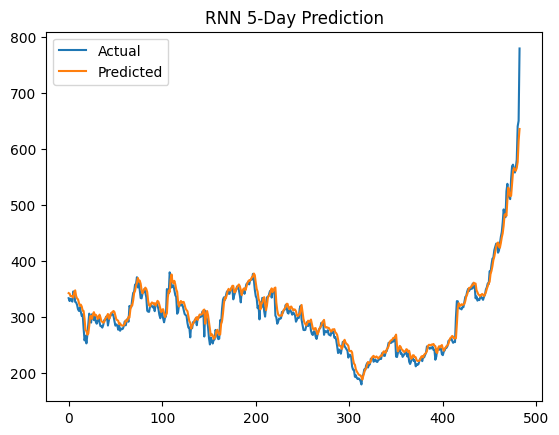

In [118]:
plt.plot(y5_test_inv, label='Actual')
plt.plot(pred_rnn5_inv, label='Predicted')
plt.title("RNN 5‑Day Prediction")
plt.legend(); plt.show()

In [119]:
lstm_5d = build_lstm(units=50, dropout_rate=0.2)
lstm_5d.fit(X5_train, y5_train, epochs=30, batch_size=32)

pred_lstm5 = lstm_5d.predict(X5_test)
pred_lstm5_inv = scaler.inverse_transform(pred_lstm5)

print("LSTM 5‑day MSE:", mean_squared_error(y5_test_inv, pred_lstm5_inv))




Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0107
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1828e-04
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9301e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4198e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9049e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0339e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4576e-04
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7656e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3920e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3397e-04
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9290e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9460e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1446e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6597e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━

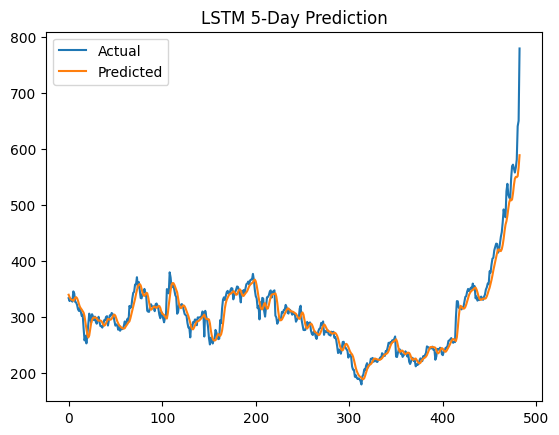

In [120]:
plt.plot(y5_test_inv, label='Actual')
plt.plot(pred_lstm5_inv, label='Predicted')
plt.title("LSTM 5‑Day Prediction")
plt.legend(); plt.show()

In [121]:
# RNN 10‑day
rnn_10d = build_rnn(units=50, dropout_rate=0.2)
rnn_10d.fit(X10_train, y10_train, epochs=30, batch_size=32)

pred_rnn10 = rnn_10d.predict(X10_test)
pred_rnn10_inv = scaler.inverse_transform(pred_rnn10)
y10_test_inv = scaler.inverse_transform(y10_test)

print("RNN 10‑day MSE:", mean_squared_error(y10_test_inv, pred_rnn10_inv))



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7297e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1895e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3503e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8578e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4410e-04
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5522e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5015e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4637e-04
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5570e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7249e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3730e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9981e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━━━━

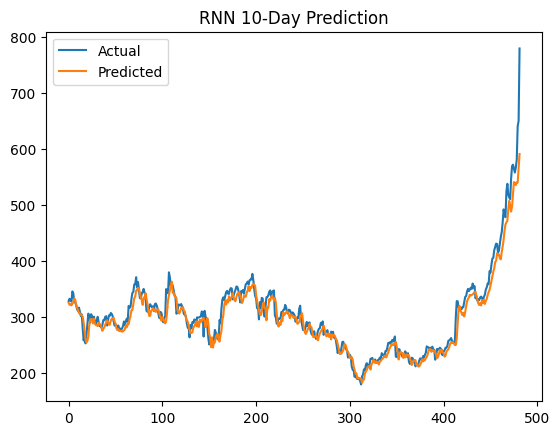

In [122]:
plt.plot(y10_test_inv, label='Actual')
plt.plot(pred_rnn10_inv, label='Predicted')
plt.title("RNN 10‑Day Prediction")
plt.legend(); plt.show()




In [124]:
# LSTM 10‑day
lstm_10d = build_lstm(units=50, dropout_rate=0.2)
lstm_10d.fit(X10_train, y10_train, epochs=30, batch_size=32)

pred_lstm10 = lstm_10d.predict(X10_test)
pred_lstm10_inv = scaler.inverse_transform(pred_lstm10)

print("LSTM 10‑day MSE:", mean_squared_error(y10_test_inv, pred_lstm10_inv))



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0103
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1564e-04
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4891e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2904e-04
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4725e-04
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6660e-04
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5697e-04
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6878e-04
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1606e-04
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5426e-04
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2272e-04
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2370e-04
Epoch 13/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7130e-04
Epoch 14/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7315e-04
Epoch 15/30
61/61 ━━━━━━━━━━━━━━━

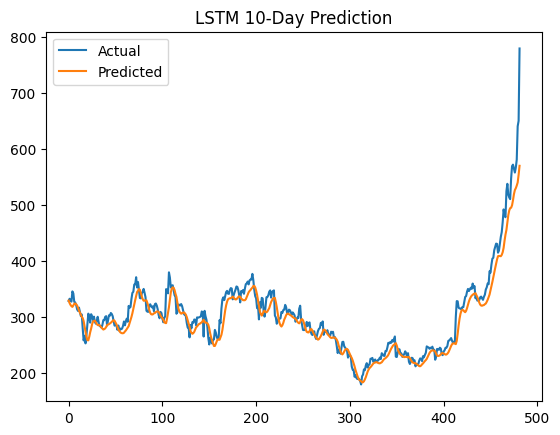

In [125]:
plt.plot(y10_test_inv, label='Actual')
plt.plot(pred_lstm10_inv, label='Predicted')
plt.title("LSTM 10‑Day Prediction")
plt.legend(); plt.show()